
# LLM Run Analysis Notebook

This notebook analyzes a completed run stored in Postgres (tables: `llm_runs`, `llm_predictions`) and produces:
- Overall accuracy & invalid percentage
- Confusion matrix (gold vs. predicted)
- Accuracy by gold relevance bucket
- Latency statistics (mean, median, p95) and outliers
- Samples of **mispredictions** and **invalid** predictions for qualitative error analysis
- Optional: simple text mining of `pred_reason` to surface common failure themes

> **How to use**
> 1. Fill in your Postgres credentials, `AUDIT_SCHEMA`, and `RUN_KEY` below.
> 2. Run the cells top-to-bottom.
> 3. Tweak limits/filters as you like.


In [12]:

# --- Configuration ---
PG_HOST = "127.0.0.1"
PG_PORT = 5432
PG_DB   = "bachelor-thesis"
PG_USER = "postgres"
PG_PASS = "123"

# Your audit schema name (matches cfg.audit_schema from your run)
AUDIT_SCHEMA = "passagev2"

# The run you want to analyze (from bt.db.gen_run_key / llm_runs.run_key)
RUN_KEY = "SCWFFWMC2NDP"

# Sample sizes for browsing mistakes/invalids
MAX_SHOW_MISPREDICTIONS = 30
MAX_SHOW_INVALID = 30


In [5]:

import psycopg2, psycopg2.extras
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

def connect():
    dsn = f"host={PG_HOST} port={PG_PORT} dbname={PG_DB} user={PG_USER} password={PG_PASS}"
    conn = psycopg2.connect(dsn)
    return conn

def read_sql(conn, sql, params=None):
    with conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor) as cur:
        cur.execute(sql, params or ())
        rows = cur.fetchall()
        return pd.DataFrame(rows)

def pretty_pct(x):
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return "N/A"
    return f"{x*100:.2f}%"



## 1) Sanity checks

In [17]:

conn = connect()

df_run = read_sql(conn, f"""
    SELECT run_key, created_at, finished, finished_at,
           model, prompt_template, data_schema, audit_schema_name,
           max_text_chars, commit_every, limit_qrels, temperature,
           retry_enabled, retry_attempts, retry_backoff_ms,
           total_items, valid_predictions, agreement_pct, invalid_pct,
           start_qrel, end_qrel, official, user_notes,
           git_commit, git_branch, git_dirty
    FROM {AUDIT_SCHEMA}.llm_runs
    WHERE run_key = %s
""", (RUN_KEY,))

df_preds = read_sql(conn, f"""
    SELECT run_key, idx, query_id, doc_id, gold_score, pred_score, is_correct, ms_total,
           pred_reason,
           COALESCE(raw_response->>'error','') as error,
           COALESCE(raw_response->>'response_text','') as response_text
    FROM {AUDIT_SCHEMA}.llm_predictions
    WHERE run_key = %s
    ORDER BY idx
""", (RUN_KEY,))

print("Run found:", len(df_run)==1)
print("Predictions:", len(df_preds))
df_run


Run found: True
Predictions: 1000


,run_key,created_at,finished,finished_at,model,prompt_template,data_schema,audit_schema_name,max_text_chars,commit_every,...,valid_predictions,agreement_pct,invalid_pct,start_qrel,end_qrel,official,user_notes,git_commit,git_branch,git_dirty
0,DPXBFT9D4VTP,2025-09-25 07:04:36.653243-07:00,True,2025-09-25 08:23:25.563700-07:00,ollama:deepseek-r1:1.5b,You are a relevance judge for document retriev...,passage,passage,None,5,...,0,None,1.2,1,1000,False,test run,a008366,main,True


## 2) Overall metrics

In [7]:

n = len(df_preds)
invalid = df_preds['pred_score'].isna().sum()
valid = n - invalid
acc = (df_preds['is_correct'].fillna(False)).mean() if n>0 else 0.0
invalid_pct = invalid / n if n>0 else 0.0

summary = pd.DataFrame({
    'metric': ['items','valid_predictions','invalid_predictions','agreement_rate','invalid_pct'],
    'value':  [n, valid, invalid, acc, invalid_pct]
})
summary['value_fmt'] = summary.apply(lambda r: pretty_pct(r['value']) if 'pct' in r['metric'] or 'rate' in r['metric'] else r['value'], axis=1)
summary


C:\Users\donista\AppData\Local\Temp\ipykernel_12800\1204723773.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  acc = (df_preds['is_correct'].fillna(False)).mean() if n>0 else 0.0


,metric,value,value_fmt
0,items,1000.000,1000.0
1,valid_predictions,988.000,988.0
2,invalid_predictions,12.000,12.0
3,agreement_rate,0.359,35.90%
4,invalid_pct,0.012,1.20%


## 3) Confusion matrix (gold vs pred)

In [8]:

cm = (df_preds
      .dropna(subset=['pred_score'])
      .pivot_table(index='gold_score', columns='pred_score', values='idx', aggfunc='count', fill_value=0)
      .astype(int))
cm


pred_score,0.0,1.0,2.0,3.0
gold_score,,,,
0,113,73,46,14
1,57,66,100,21
2,36,49,119,46
3,42,34,111,61


## 4) Accuracy by gold relevance

In [9]:

acc_by_gold = (df_preds
    .assign(is_correct=df_preds['is_correct'].fillna(False).astype(int))
    .groupby('gold_score', dropna=False)['is_correct']
    .agg(['mean','count'])
    .rename(columns={'mean':'accuracy','count':'n'})
    .reset_index()
)
acc_by_gold['accuracy_fmt'] = acc_by_gold['accuracy'].map(pretty_pct)
acc_by_gold


C:\Users\donista\AppData\Local\Temp\ipykernel_12800\125484495.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .assign(is_correct=df_preds['is_correct'].fillna(False).astype(int))


,gold_score,accuracy,n,accuracy_fmt
0,0,0.452,250,45.20%
1,1,0.264,250,26.40%
2,2,0.476,250,47.60%
3,3,0.244,250,24.40%


## 5) Latency stats & distribution

In [ ]:

lat = df_preds['ms_total'].dropna().astype(float)
lat_stats = {
    'mean_ms': lat.mean(),
    'median_ms': lat.median(),
    'p95_ms': lat.quantile(0.95) if len(lat)>0 else None,
    'max_ms': lat.max()
}
pd.DataFrame([lat_stats])


In [ ]:

# Histogram (matplotlib; no seaborn; single-plot; no explicit colors)
plt.figure()
plt.hist(df_preds['ms_total'].dropna().astype(float), bins=30)
plt.title("Latency distribution (ms)")
plt.xlabel("ms_total")
plt.ylabel("count")
plt.show()


## 6) Error categories

In [10]:

df_preds['err_category'] = np.where(df_preds['pred_score'].isna(),
                                    np.where(df_preds['error'].str.contains('timeout', case=False, na=False), 'timeout', 'parse_or_other'),
                                    'ok')
err_counts = df_preds['err_category'].value_counts(dropna=False).rename_axis('err_category').reset_index(name='n')
err_counts


,err_category,n
0,ok,988
1,parse_or_other,11
2,timeout,1


## 7) Sample **mispredictions** (wrong but not NULL)

In [11]:

mispreds = df_preds[(df_preds['pred_score'].notna()) & (df_preds['is_correct'] == False)]
mispreds_sample = mispreds.sample(min(len(mispreds), MAX_SHOW_MISPREDICTIONS), random_state=42) if len(mispreds)>0 else mispreds
mispreds_sample[['idx','query_id','doc_id','gold_score','pred_score','pred_reason','response_text']]


,idx,query_id,doc_id,gold_score,pred_score,pred_reason,response_text
803,804,451602,4874644,1,3.0,None,"<think>\nOkay, so I need to figure out how rel..."
420,421,1133167,8415745,0,1.0,None,"<think>\nOkay, so I need to figure out how rel..."
876,877,527433,1379237,3,1.0,None,"<think>\nOkay, so I need to figure out how rel..."
357,358,1124210,92049,2,3.0,None,"<think>\nOkay, so I need to figure out how rel..."
847,848,489204,1664640,2,0.0,None,"<think>\nOkay, so I need to figure out how rel..."
814,815,451602,7510020,0,2.0,None,"<think>\nOkay, so I need to figure out how rel..."
750,751,359349,68647,3,1.0,None,"<think>\nOkay, so I need to figure out how rel..."
140,141,1112341,1035064,3,0.0,None,"<think>\nOkay, so I need to figure out how rel..."
845,846,489204,1310101,0,2.0,None,"<think>\nOkay, so I need to figure out how rel..."
227,228,1114819,344350,3,2.0,None,"<think>\nOkay, so I need to figure out how rel..."


## 8) Sample **invalid predictions** (pred_score is NULL)

In [ ]:

invalids = df_preds[df_preds['pred_score'].isna()]
invalids_sample = invalids.sample(min(len(invalids), MAX_SHOW_INVALID), random_state=42) if len(invalids)>0 else invalids
invalids_sample[['idx','query_id','doc_id','gold_score','error','response_text']]


## 9) Per-query aggregates (which queries fail the most?)

In [12]:

per_query = (df_preds
             .assign(correct=df_preds['is_correct'].fillna(False).astype(int),
                     invalid=(df_preds['pred_score'].isna()).astype(int))
             .groupby('query_id', as_index=False)
             .agg(n=('idx','count'),
                  acc=('correct','mean'),
                  invalid_pct=('invalid','mean'))
             .sort_values(['acc','n'], ascending=[True, False]))

# Show worst 20 by accuracy (with at least 3 items so it's meaningful)
per_query_filtered = per_query[per_query['n'] >= 3].head(20)
per_query_filtered


C:\Users\donista\AppData\Local\Temp\ipykernel_12800\1145731616.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .assign(correct=df_preds['is_correct'].fillna(False).astype(int),


,query_id,n,acc,invalid_pct
6,1112341,38,0.052632,0.052632
37,833860,14,0.071429,0.000000
8,1114646,18,0.111111,0.000000
25,19335,20,0.150000,0.000000
31,451602,38,0.157895,0.000000
33,489204,19,0.157895,0.000000
30,443396,17,0.176471,0.000000
32,47923,21,0.190476,0.000000
35,527433,18,0.222222,0.000000
36,573724,18,0.222222,0.000000


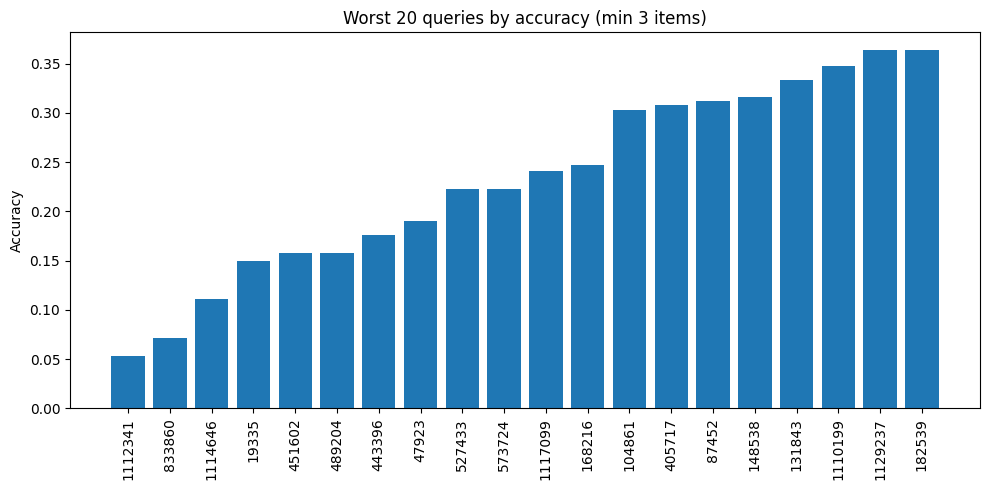

In [13]:

# Plot per-query accuracy for the worst 20 (no seaborn; single-plot; no explicit colors)
plt.figure(figsize=(10,5))
plot_df = per_query_filtered.sort_values('acc')
plt.bar(plot_df['query_id'].astype(str), plot_df['acc'])
plt.xticks(rotation=90)
plt.title("Worst 20 queries by accuracy (min 3 items)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


## 10) (Optional) Quick text mining of `pred_reason`

In [14]:

# Very light-weight: look for frequent tokens in reasons of mispredictions
from collections import Counter
import re

def tokenize(text):
    return re.findall(r"[a-zA-Z]{3,}", text.lower())

reasons = " ".join((mispreds_sample['pred_reason'].dropna().astype(str)).tolist())
tokens = tokenize(reasons)
common = Counter(tokens).most_common(40)
pd.DataFrame(common, columns=['token','count'])


,token,count


In [15]:

conn.close()
print("Done.")


Done.


In [18]:
df_preds_grouped = df_preds.copy()

# Define a "grouped_gold" and "grouped_pred"
def group_label(x):
    if pd.isna(x):
        return None
    if x in [1,2]:
        return "1_or_2"
    return str(int(x))  # keep 0 and 3 separate

df_preds_grouped["gold_group"] = df_preds_grouped["gold_score"].apply(group_label)
df_preds_grouped["pred_group"] = df_preds_grouped["pred_score"].apply(group_label)

# Correctness under grouped labels
df_preds_grouped["is_correct_grouped"] = (
    (df_preds_grouped["gold_group"] == df_preds_grouped["pred_group"])
)

agreement_grouped = df_preds_grouped["is_correct_grouped"].mean()
print(f"Grouped agreement (1+2 merged): {agreement_grouped:.2%}")


Grouped agreement (1+2 merged): 50.80%


In [13]:
DATA_SCHEMA = "passagev2"  # change if your qrels are in another schema

conn = connect()

sql_summary = f"""
WITH preds AS (
  SELECT query_id::text AS query_id,
         doc_id::text   AS doc_id,
         pred_score
  FROM {AUDIT_SCHEMA}.llm_predictions
  WHERE run_key = %s AND pred_score IS NOT NULL
),
personal AS (
  SELECT q.query_id::text AS query_id,
         q.doc_id::text   AS doc_id,
         q.personal_score
  FROM {DATA_SCHEMA}.qrels q
  WHERE q.personal_score IS NOT NULL
)
SELECT
  COUNT(*) AS compared,
  SUM((preds.pred_score = personal.personal_score)::int) AS agree,
  SUM((preds.pred_score <> personal.personal_score)::int) AS disagree,
  COALESCE(AVG((preds.pred_score = personal.personal_score)::int)::float, 0) AS agreement_rate
FROM preds
JOIN personal USING (query_id, doc_id);
"""

summary_df = read_sql(conn, sql_summary, params=(RUN_KEY,))
summary_df["agreement_rate_pretty"] = summary_df["agreement_rate"].apply(pretty_pct)
display(summary_df)

conn.close()


,compared,agree,disagree,agreement_rate,agreement_rate_pretty
0,998,687,311,0.688377,68.84%
